# MLSyPred ML Models Antimalarial PIPELINE Version 0.9.6

MLSyPred ML Models Antimalarial PIPELINE 
 
The purpose of the script is to identify the core implementation for learning the ML algorithms, evaluate and obtain the models and includes the ML algorithms: Random Forest, Logistic Regression, Support-Vector Machine, AdaBoost and Gradient Boost.

Cross-Validation (CV) is utilized to compare and select the best model for this predictive modeling problem. A k size equal to 5 is used as default.

This module used the validation dataset to compute the different metrics (i.e., Accuracy, Precision, and Area Under the Curve ROC) to determine the best model. We used AUC ROC was used as the metric to decide on the best accurate model. The best model is the model with the highest AUC ROC.

The outcome of this script is to obtain the best performing ML algorithm per Plasmodium falciparum strain. 
The best performing model per strain can be used to predict other synergistic drug combinations for the domain in which it was trained, for example, antimalarials or any other drug combinatorial therapy.

Datasets used:

Mason, D. J., Eastman, R. T., Lewis, R., Stott, I. P., Guha, R., & Bender, A. (2018). Using Machine Learning to Predict Synergistic Antimalarial Compound Combinations With Novel Structures. Frontiers in pharmacology, 9, 1096. https://doi.org/10.3389/fphar.2018.01096

Mott, B. T., Eastman, R. T., Guha, R., Sherlach, K. S., Siriwardana, A., Shinn, P., McKnight, C., Michael, S., Lacerda-Queiroz, N., Patel, P. R., Khine, P., Sun, H., Kasbekar, M., Aghdam, N., Fontaine, S. D., Liu, D., Mierzwa, T., Mathews-Griner, L. A., Ferrer, M., Renslo, A. R., … Thomas, C. J. (2015). High-throughput matrix screening identifies synergistic and antagonistic antimalarial drug combinations. Scientific reports, 5, 13891. https://doi.org/10.1038/srep13891

### Import the necessary libraries

In [54]:
import os
import pandas as pd
import numpy as np
import argparse
import seaborn as sns
import statistics
import matplotlib.pyplot as plt
import sklearn as sklearn
from scipy import interp
from sklearn.datasets import make_classification
from sklearn import preprocessing, metrics
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.feature_selection import SelectKBest, SelectPercentile, chi2, f_classif, mutual_info_classif, RFE, RFECV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import LogisticRegression, Ridge, RidgeCV, LassoCV, Lasso, Perceptron
from sklearn.neural_network import MLPClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.utils import class_weight
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score,\
confusion_matrix, roc_curve, auc, plot_roc_curve
from sklearn.decomposition import PCA
from mpl_toolkits import mplot3d
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
import subprocess
import scikitplot as skplt
from scipy.interpolate import interp1d

import pickle

### Encoder to change strings to labels

Look for values 0 & 1 that should be treated as labels and converts them to factors

In [55]:
def encode_labels(file):
    for col in file:
        if len(file[col].unique()) == 2:
            file[col] = file[col].astype('bool',copy=False)             
            # 0 becomes FALSE and 1 becomes TRUE
    return 


### Load the data

ALL_SET_ML_Morgan2048_3D7_UPDATED.csv is a csv that has both the Training and Validation OUTPUT files from MLSyPred-COMBINATION PIPELINE into one file.

In [62]:
#overall_data = pd.read_csv(file)                                        
# Load the data
#print('Number of patients in the data set: ', len(overall_data))

#overall_data.head()

filename="ALL_SET_ML_Morgan2048_Mason2018_DD2_UPDATED.csv"

data = pd.read_csv(filename)

# Compute the correlation matrix
corr = data.corr().round(1)
#print(corr)

#for i in range(0,117):
#    for j in range(0,117):
#        if corr.iloc[i][j] >= 0.8 or corr.iloc[i][j] <= -0.8:
#            print(corr.index[i][0],corr.iloc[i][j])


corr.to_csv('corr.csv')

df=pd.read_csv('corr.csv')

corrpos=0.8
corrneg=-0.8

df2=df
df3 = df2[df2.columns[1:]]
#print(df2.shape)
#print(df3.shape)

df4 = df3.where(np.tril(np.ones(df3.shape),k=-1).astype(np.bool))
#print(df4)
to_droppost = [column for column in df4.columns if any(df4[column] >= corrpos)]
#print(to_droppost)
df4.drop(to_droppost, axis=1, inplace=True)
#print(df4)
to_dropnega = [column for column in df4.columns if any(df4[column] <= corrneg)]
df4.drop(to_dropnega, axis=1, inplace=True)
##print(df4)
df5=df4
col=df5.columns.tolist()
print(col)


['2', '5', '11', '14', '22', '28', '30', '32', '43', '44', '46', '54', '81', '84', '85', '91', '95', '116', '118', '119', '120', '131', '141', '155', '176', '192', '203', '204', '205', '208', '216', '227', '228', '232', '234', '238', '244', '249', '250', '252', '254', '256', '263', '268', '274', '277', '278', '279', '284', '290', '295', '306', '311', '315', '318', '320', '330', '336', '341', '350', '351', '353', '362', '367', '379', '381', '384', '388', '390', '393', '396', '408', '420', '459', '465', '476', '486', '487', '491', '492', '503', '508', '511', '522', '523', '545', '565', '574', '585', '588', '598', '621', '630', '639', '641', '642', '645', '651', '653', '654', '657', '662', '667', '668', '674', '675', '676', '680', '681', '683', '688', '690', '695', '700', '704', '709', '712', '716', '719', '727', '729', '733', '737', '738', '740', '746', '748', '751', '760', '771', '785', '786', '795', '799', '805', '808', '812', '816', '817', '826', '833', '835', '837', '842', '843', '84

### Generate a correlation matrix to observe if any linear dependencies exist (Continuous Variables Only)


Anything above an r value bigger than 0.8 or 0.9 between independent variables should be removed

In [63]:
sns.set(style="white")

# Compute the correlation matrix
#corr = data.corr().round(1)
#print(corr)

#for i in range(0,117):
#    for j in range(0,117):
#        if corr.iloc[i][j] >= 0.8 or corr.iloc[i][j] <= -0.8:
#            print(corr.index[i][0],corr.iloc[i][j])

#corr.to_csv('corr.csv')


# Generate a mask for the upper triangle
#mask = np.zeros_like(corr, dtype=np.bool)
#mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
#f, ax = plt.subplots(figsize=(64, 64))

# Generate a custom diverging colormap
#cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
#sns_plot = sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
#            square=True, linewidths=0.5, cbar_kws={"shrink": 0.5}, annot=True, annot_kws={"size": 12})

#plt.savefig("Corr.png", dpi=400,bbox_inches='tight')


### Split the data into training and testing sets using stratification for the predicted class


In [64]:
#X_train, X_test, y_train, y_test = train_test_split(data, label, test_size=test_split, random_state=42, stratify=label)

X_train = pd.read_csv(filename)
#X_test = pd.read_csv("Files_to_run/VALIDATION_SET_ML_Morgan2048_DD2_UPDATED.csv")
#X_train = pd.read_csv("TRAINING_SET_ML_X.csv")                                        
#X_test = pd.read_csv("VALIDATION_SET_ML_X.csv")
#y_train_T = pd.read_csv("TRAINING_SET_ML_Y.csv")
#y_test_T = pd.read_csv("VALIDATION_SET_ML_Y.csv")

X_train = X_train[col]
#X_test = X_test[col]

y_train_T = pd.DataFrame(X_train.iloc[:,-1])
#y_test_T = pd.DataFrame(X_test.iloc[:,-1])
X_train = X_train.drop(labels=['SYNERGY'], axis=1)
#X_test = X_test.drop(labels=['SYNERGY'], axis=1)

column_names = X_train.columns.values.tolist() 

encode_labels(y_train_T)
#encode_labels(y_test_T)

y_train = y_train_T.T.iloc[0]
#y_test = y_test_T.T.iloc[0]


#train_file = pd.concat([X_train, y_train], axis=1, sort=False)
#test_file = pd.concat([X_test, y_test], axis=1, sort=False)

#train_file.to_csv("Training_file.csv",index=False)
#test_file.to_csv("Test_file.csv",index=False)


### PCA Plot Before Oversampling


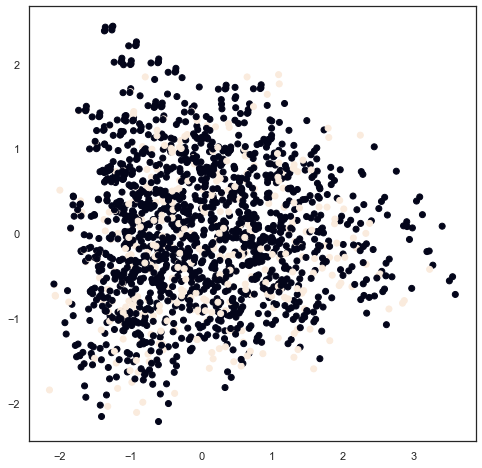

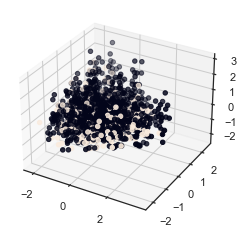

In [65]:
pca = PCA(n_components=2)
pca.fit(X_train)
X_pca = pca.transform(X_train)

%matplotlib inline
plt.figure(figsize=(8,8))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_train)
plt.show()


# 3D
fig = plt.figure()
ax= plt.axes(projection='3d')

pca = PCA(n_components=3)
pca.fit(X_train)
X_pca = pca.transform(X_train)

ax.scatter3D(X_pca[:, 0], X_pca[:, 1], X_pca[:,2], c=y_train)
plt.show()

### Choose the number of K-folds to use for the data at hand

In [66]:
# The first two numbers are what are considered standard according to literature (5 and 10 folds)
nfolds = 5                                              
#nfolds = 10

# This is known as leave one out CV which trains on every sample of the minority class in the training set
#nfolds = len(y_train[y_train==1])-1                                    
                                              
print('Number of K-Folds to be used: ' + str(nfolds))



Number of K-Folds to be used: 5


### Determine Class Weights (Only Choose This Block Or The Oversampling One, Not Both)

There's three methods implemented. The first approach takes the inverse of the number of samples in each class as it's respective weight( 1 / n_samples_in_class). The second one uses sklearn's implemented method using this formula: n_samples / (n_classes * np.bincount(y)). Its important to note that ANN, NB and KNN do not support class weighting, unbalanced sampling should be used in these cases. The last one is not using weight balancing at all and gives both labels a weight of 1

In [67]:
# Approach 1
#weights = {0:1/sum(y_train==0), 1:1/sum(y_train==1)}

# Approach 2
weights = class_weight.compute_class_weight('balanced',np.unique(y_train),y_train)
weights = {0:weights[0], 1:weights[1]}
weights

# Approach 3 - No weighting
#weights = None

{0: 0.6326825741142444, 1: 2.3841961852861036}

### Fit the chosen RFE model to determine the optimum number of features

In [70]:
model=LogisticRegression()
rfecv = RFECV(estimator=model, step=1, min_features_to_select=5, cv=StratifiedKFold(nfolds),scoring='roc_auc')      
# Declare the model RFECV will use
rfecv.fit(X_train, y_train)                                                               
# Fit the model

print("Optimal number of features: %d" % rfecv.n_features_)                               
# Print the number of optimal features

Optimal number of features: 72


### Declare the Models and Parameters Before GridSearchCV

These are all the models that will run and all their functions

In [71]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier


models1 = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(),
    'AdaBoost': AdaBoostClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'SVM': SVC(),
}

params1 = {
    'Logistic Regression': [
        {'penalty': ['l1'], 'solver': ['liblinear']},
        {'penalty': ['l2'], 'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag']}],
    
    'Random Forest': {'n_estimators': [i for i in range(100,600,100)], 'criterion': ['gini', 'entropy'], 'n_jobs': [-1]},
    
    'AdaBoost':  {'algorithm': ['SAMME', 'SAMME.R']},
    
    'Gradient Boosting': {'loss' : ['deviance', 'exponential'], 'learning_rate': [i/10 for i in range(1,5)], 
                          'n_estimators': [i for i in range(100,300,100)]},
    'SVM': [
        {'kernel': ['linear'], 'C': [i for i in range(1,10)]}]}#,
        #{'kernel': ['rbf'], 'C': [i for i in range(1,10)], 'gamma': [0.1, 0.001, 0.0001]}]}

### Run Grid Search For All Models

Table of all relevant data of the best performing models for each dataset

In [72]:
import warnings
warnings.filterwarnings('ignore')


class EstimatorSelectionHelper:

    def __init__(self, models, params):
        if not set(models.keys()).issubset(set(params.keys())):
            missing_params = list(set(models.keys()) - set(params.keys()))
            raise ValueError("Some estimators are missing parameters: %s" % missing_params)
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv=3, n_jobs=3, verbose=0, scoring=None, refit=False):
        for key in self.keys:
            model = self.models[key]
            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs, 
                          scoring=scoring, refit=refit,
                          return_train_score=True)
            gs.fit(X,y)
            self.grid_searches[key] = gs    

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                 'estimator': key,
                 'min_score': min(scores),
                 'max_score': max(scores),
                 'mean_score': np.mean(scores),
                 'std_score': np.std(scores),
            }
            return pd.Series({**params,**d})

        rows = []
        for k in self.grid_searches:
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]        
                scores.append(r.reshape(len(params),1))

            all_scores = np.hstack(scores)
            for p, s in zip(params,all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)

        columns = ['estimator', 'min_score', 'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]

        return df[columns]

helper1 = EstimatorSelectionHelper(models1, params1)
helper1.fit(X_train, y_train, scoring='roc_auc', n_jobs=-1)

GS_Results = helper1.score_summary(sort_by='mean_score')
GS_Results['mean_score'] = pd.to_numeric(GS_Results['mean_score']) 

### Filter Results to Obtain the Best Models Only

Table of all relevant data of the best performing models for each dataset

In [73]:
LR = GS_Results[GS_Results.estimator=='Logistic Regression']
RF = GS_Results[GS_Results.estimator=='Random Forest']
AB = GS_Results[GS_Results.estimator=='AdaBoost']
GB = GS_Results[GS_Results.estimator=='Gradient Boosting']
SV = GS_Results[GS_Results.estimator=='SVM']
Best_Models = pd.concat([LR.nlargest(1, 'mean_score'),RF.nlargest(1, 'mean_score'),AB.nlargest(1, 'mean_score'),GB.nlargest(1, 'mean_score'),SV.nlargest(1, 'mean_score')])
Best_Models


,estimator,min_score,mean_score,max_score,std_score,penalty,solver,criterion,n_estimators,n_jobs,algorithm,learning_rate,loss,C,kernel
3,Logistic Regression,0.701895,0.755831,0.82001,0.048761,l2,liblinear,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13,Random Forest,0.717696,0.751631,0.80751,0.039815,NaN,NaN,entropy,400,-1,NaN,NaN,NaN,NaN,NaN
16,AdaBoost,0.661967,0.717411,0.803848,0.06193,NaN,NaN,NaN,NaN,NaN,SAMME.R,NaN,NaN,NaN,NaN
31,Gradient Boosting,0.663598,0.721057,0.809253,0.063311,NaN,NaN,NaN,100,NaN,NaN,0.4,exponential,NaN,NaN
39,SVM,0.669524,0.716412,0.806177,0.063494,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7,linear


In [74]:
rfe_models = []

rfe_models.append(("Logistic Regression", LogisticRegression(random_state=42,solver=Best_Models.iloc[0]['solver'],penalty=Best_Models.iloc[0]['penalty'],class_weight=weights,max_iter=1000)))

rfe_models.append(("SVM", SVC(kernel="linear", class_weight=weights, C=Best_Models.iloc[4]['C'], probability=True)))  #,gamma=0.1)))

rfe_models.append(("Random Forest", RandomForestClassifier(n_estimators=Best_Models.iloc[1]['n_estimators'],max_depth=None,max_features=None,random_state=42, criterion=Best_Models.iloc[1]['criterion'],class_weight=weights)))

rfe_models.append(('AdaBoost',AdaBoostClassifier(algorithm=Best_Models.iloc[2]['algorithm'])))
    
rfe_models.append(('Gradient Boosting', GradientBoostingClassifier(loss=Best_Models.iloc[3]['loss'],learning_rate=Best_Models.iloc[3]['learning_rate'] ,n_estimators=Best_Models.iloc[3]['n_estimators'])))

for models in rfe_models:
    print(models)

('Logistic Regression', LogisticRegression(class_weight={0: 0.6326825741142444, 1: 2.3841961852861036},
                   max_iter=1000, random_state=42, solver='liblinear'))
('SVM', SVC(C=7, class_weight={0: 0.6326825741142444, 1: 2.3841961852861036},
    kernel='linear', probability=True))
('Random Forest', RandomForestClassifier(class_weight={0: 0.6326825741142444,
                                     1: 2.3841961852861036},
                       criterion='entropy', max_features=None, n_estimators=400,
                       random_state=42))
('AdaBoost', AdaBoostClassifier())
('Gradient Boosting', GradientBoostingClassifier(learning_rate=0.4, loss='exponential'))


### Apply the parameters for each model 

You must use specifically the best model for each dataset
If we want to run new compounds, it is only to make new models
It is NOT to predict synergy combinations

In [82]:

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.20, random_state=123)


In [83]:
LG =LogisticRegression(class_weight={0: 0.6326825741142444, 1: 2.3841961852861036}, max_iter=1000, random_state=42, solver='liblinear')
LG.fit(X_train, y_train)
Y_predicted= LG.predict(X_test)
print("accuracy: " + str( accuracy_score(y_test,Y_predicted)))
print("precision: " + str(precision_score(y_test,Y_predicted)))
print("recall: " + str(recall_score(y_test,Y_predicted)))
print("roc_auc_score: " + str(roc_auc_score(y_test,Y_predicted)))
print("f1: " + str(f1_score(y_test,Y_predicted)))
print("confusion_matrix: " + str(confusion_matrix(y_test,Y_predicted)))


accuracy: 0.8040816326530612
precision: 0.4788732394366197
recall: 0.7555555555555555
roc_auc_score: 0.7852777777777777
f1: 0.5862068965517241
confusion_matrix: [[163  37]
 [ 11  34]]


In [84]:
SVM=SVC(C=7, class_weight={0: 0.6326825741142444, 1: 2.3841961852861036},
    kernel='linear', probability=True)
SVM.fit(X_train, y_train)
Y_predicted= SVM.predict(X_test)
print("accuracy: " + str( accuracy_score(y_test,Y_predicted)))
print("precision: " + str(precision_score(y_test,Y_predicted)))
print("recall: " + str(recall_score(y_test,Y_predicted)))
print("roc_auc_score: " + str(roc_auc_score(y_test,Y_predicted)))
print("f1: " + str(f1_score(y_test,Y_predicted)))
print("confusion_matrix: " + str(confusion_matrix(y_test,Y_predicted)))

accuracy: 0.7877551020408163
precision: 0.4533333333333333
recall: 0.7555555555555555
roc_auc_score: 0.7752777777777777
f1: 0.5666666666666667
confusion_matrix: [[159  41]
 [ 11  34]]


In [85]:
ADB= AdaBoostClassifier()
ADB.fit(X_train, y_train)
Y_predicted= ADB.predict(X_test)
print("accuracy: " + str( accuracy_score(y_test,Y_predicted)))
print("precision: " + str(precision_score(y_test,Y_predicted)))
print("recall: " + str(recall_score(y_test,Y_predicted)))
print("roc_auc_score: " + str(roc_auc_score(y_test,Y_predicted)))
print("f1: " + str(f1_score(y_test,Y_predicted)))
print("confusion_matrix: " + str(confusion_matrix(y_test,Y_predicted)))

accuracy: 0.8612244897959184
precision: 0.7037037037037037
recall: 0.4222222222222222
roc_auc_score: 0.6911111111111111
f1: 0.5277777777777777
confusion_matrix: [[192   8]
 [ 26  19]]


In [86]:
RF= RandomForestClassifier(class_weight={0: 0.6326825741142444,
                                     1: 2.3841961852861036},
                       criterion='entropy', max_features=None, n_estimators=400,
                       random_state=42)
RF.fit(X_train, y_train)
Y_predicted= RF.predict(X_test)
print("accuracy: " + str( accuracy_score(y_test,Y_predicted)))
print("precision: " + str(precision_score(y_test,Y_predicted)))
print("recall: " + str(recall_score(y_test,Y_predicted)))
print("roc_auc_score: " + str(roc_auc_score(y_test,Y_predicted)))
print("f1: " + str(f1_score(y_test,Y_predicted)))
print("confusion_matrix: " + str(confusion_matrix(y_test,Y_predicted)))


accuracy: 0.8530612244897959
precision: 0.68
recall: 0.37777777777777777
roc_auc_score: 0.6688888888888889
f1: 0.48571428571428565
confusion_matrix: [[192   8]
 [ 28  17]]


In [87]:
GB =  GradientBoostingClassifier(learning_rate=0.4, loss='exponential')
GB.fit(X_train, y_train)
Y_predicted= GB.predict(X_test)
print("accuracy: " + str( accuracy_score(y_test,Y_predicted)))
print("precision: " + str(precision_score(y_test,Y_predicted)))
print("recall: " + str(recall_score(y_test,Y_predicted)))
print("roc_auc_score: " + str(roc_auc_score(y_test,Y_predicted)))
print("f1: " + str(f1_score(y_test,Y_predicted)))
print("confusion_matrix: " + str(confusion_matrix(y_test,Y_predicted)))


accuracy: 0.8489795918367347
precision: 0.6428571428571429
recall: 0.4
roc_auc_score: 0.6749999999999999
f1: 0.4931506849315069
confusion_matrix: [[190  10]
 [ 27  18]]


### Run all the machine learning models with the optimal features determined by RFE 

Using each RFE method, this block will try all available machine learning models with the selected variables and output the cross validated scores. 
The best parameters from the Grid Search algorithm need to be added by hand to each model.
It will go method by method, feature by feature to generate a score each time a new feature is added (for a total of 2048) and then select the best feature combination 

In [30]:
Model = []
prediction_l = []
methods = []
results = []
names = []
nvar = []

ranked_vars_names = []

i = 0

saved_model_filename = ""

#plt.figure(figsize=(14,12), dpi=300)

for method, rfe in rfe_models:
    rfecv = RFECV(estimator=rfe, step=1, min_features_to_select=5, cv=StratifiedKFold(nfolds),scoring='roc_auc')  
    # Declare the model RFECV will use
    rfecv.fit(X_train, y_train)                                                         
    # Fit the model
    topn = pd.DataFrame(X_train.columns[rfecv.support_==True]) 
    ranks = pd.DataFrame(rfecv.ranking_)                            
    # Save the feature rankings
    column_names = pd.DataFrame(column_names)                       
    # Save the column names of the original data
    cv_scores = pd.DataFrame(rfecv.grid_scores_)
    cv_scores = cv_scores.sort_values(cv_scores.columns[0],ascending=False)
    
    #if i == 0 or i == 1:
    #coefficients = pd.DataFrame(rfecv.estimator_.coef_[0])
    #else:
    coefficients = pd.DataFrame(rfecv.estimator_.feature_importances_)
     
    
    ranked_vars = pd.concat([topn, coefficients, abs(coefficients)],axis=1)
    ranked_vars.columns = ['Variable', 'Coefficient', 'Coefficient Absolute Value']
    ranked_vars.sort_values(by=['Coefficient Absolute Value'], ascending=False, inplace=True)
    ranked_vars.dropna(inplace=True)
    ranked_vars=ranked_vars[0:rfecv.n_features_]
    
    #ranked_vars = ranked_vars[ranked_vars.Importance==1]            
    # Extract the important features determined by RFE
    #ranked_vars_names += [ranked_vars["Variable"]]
    
    # Code to gather the best variables goes here
    
    saved_model_filename = filename.replace('.csv','_') + method + ".sav"
    X_train_bestvars = X_train[ranked_vars.Variable]
    new_model = rfe.fit(X_train_bestvars, y_train)
    pickle.dump(new_model, open(saved_model_filename,'wb'))
    pickle.dump(ranked_vars.Variable, open(saved_model_filename.replace('.sav','.variables'),'wb'))
    
    print(method)
    print(ranked_vars)
    print(cv_scores.iloc[0])
    #X_train_bestvars = X_train[ranked_vars.Variable] 
    # Remove columns that were not considered important in RFE
    #X_test_bestvars = X_test[ranked_vars.Variable]                  
    # Remove columns that were not considered important in RFE 
    
    #Model.append(rfe.fit(X_train_bestvars, y_train))  
    # Fits the model
    
    #prediction = rfe.predict(X_test_bestvars)                 
    # Uses training and testing instead of CV
    #methods.append(method)
    #names.append(method)
    #nvar.append(rfecv.n_features_)
    #fpr, tpr, thresholds = metrics.roc_curve(y_test, Model[i].predict_proba(X_test_bestvars)[:,1])
    
    #auc = metrics.roc_auc_score(y_test,Model[i].predict_proba(X_test_bestvars)[:,1])
    
    #plt.plot(fpr, tpr, label='%s (AUC = %0.3f)' % (method, auc))
    
    #results.append(auc)           
    # Adds AUC to results dataframe
    i+=1
    

#plt.plot([0, 1], [0, 1],'r--')
#plt.xlim([0.0, 1.0])
#plt.ylim([0.0, 1.05])
#plt.xlabel('False Positive Rate')
#plt.ylabel('True Positive Rate')
#plt.title('Receiver Operating Characteristic')
#plt.legend(loc="lower right")


#plt.savefig('AUC_plot.tif',bbox_inches='tight')

#plt.show()   # Display

#names = pd.DataFrame(names)                                         
# Makes a DF with the models used       
#results = pd.DataFrame(results)                                     
# Makes a DF with the results per model
#methods = pd.DataFrame(methods)
#nvar = pd.DataFrame(nvar)
   
#scores = pd.concat([methods, names, nvar, results.mean(axis=1)], axis=1)          
# Joins the models and their results in a DF
#scores.columns=['RFE Method', 'ML Model', 'Number of variables', 'AUC Score']     
# Change the column names
#scores



AttributeError: 'LogisticRegression' object has no attribute 'feature_importances_'